
# ConveyorAI — Confidence Score via Logistic Regression

This simplified notebook removes asyncio. It:
1) Loads the Digisign dataset
2) Uses **one synchronous LLM call per row** to extract **binary failure‑mode features**
3) Labels: **1 only** if `conveyor_ai_grade == "perfect"`, else 0
4) Trains **Logistic Regression** on the full dataset
5) Shows a **confusion matrix**
6) Plots **predicted p(accurate)** vs the original categorical grade


## 0) Setup

In [1]:

import os, json, time, difflib
from typing import Any, Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

try:
    from openai import OpenAI
except Exception:
    OpenAI = None

# --- Paths & Columns ---
DATA_PATH = "human_eval_data.csv"
ID_COL = "id"
QUESTION_COL = "question"
AI_ANSWER_COL = "conveyor_ai_answer"
GRADE_COL = "conveyor_ai_grade"
SOURCE_PREFIX = "source_"

# --- LLM Config (sync) ---
MODEL_NAME = os.getenv("LLM_MODEL_NAME", "gpt-5-nano")
TEMPERATURE = float(os.getenv("LLM_TEMPERATURE", "0.0"))
SLEEP_BETWEEN_SECONDS = float(os.getenv("SLEEP_BETWEEN_SECONDS", "0.0"))  # add delay between requests if needed
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY) if (OPENAI_API_KEY and OpenAI) else None
print("LLM client initialized:", bool(client), "| Model:", MODEL_NAME)


LLM client initialized: True | Model: gpt-5-nano


## 1) Load dataset & gather sources

In [2]:

df = pd.read_csv(DATA_PATH)
print("Rows:", len(df), "Cols:", list(df.columns))

source_cols = [c for c in df.columns if c.startswith(SOURCE_PREFIX)]
print("Detected source columns:", source_cols)

def gather_sources(row) -> List[str]:
    out = []
    for c in source_cols:
        v = row.get(c)
        if pd.notna(v) and str(v).strip():
            out.append(str(v))
    return out

df["sources_list"] = df.apply(gather_sources, axis=1)
df.head(3)


Rows: 207 Cols: ['id', 'questionnaire', 'question', 'conveyor_ai_answer', 'user_updated_answer', 'conveyor_ai_grade', 'num_sources', 'source_1', 'source_2', 'source_3', 'source_4', 'source_5', 'source_6', 'source_7', 'source_8', 'source_9', 'source_10', 'source_11']
Detected source columns: ['source_1', 'source_2', 'source_3', 'source_4', 'source_5', 'source_6', 'source_7', 'source_8', 'source_9', 'source_10', 'source_11']


,id,questionnaire,question,conveyor_ai_answer,user_updated_answer,conveyor_ai_grade,num_sources,source_1,source_2,source_3,source_4,source_5,source_6,source_7,source_8,source_9,source_10,source_11,sources_list
0,NJMEL_1,NJMEL,Q1- Does the organization have a dedicated in...,Yes. The organization has a dedicated Security...,Yes. We have a dedicated Security team respons...,accurate_imperfect,3,Do you have a dedicated Information Security s...,Who is responsible for cybersecurity within th...,Digisign Security Incident Response Plan\n----...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Do you have a dedicated Information Security ...
1,NJMEL_2,NJMEL,Q2- Does your organization conduct risk asses...,Yes. Risk assessments are conducted at least a...,NaN,perfect,3,Are cyber security risk assessments performed ...,Digisign SOC 2 Type II report\n-----\nRisk Ass...,Digisign Enterprise Information Security Polic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Are cyber security risk assessments performed...
2,NJMEL_3,NJMEL,Q3- Are background and credit checks conducte...,"Yes. Background checks, including federal and ...","Yes. Background checks, including federal and ...",inaccurate,2,Digisign SOC 2 Type II report\n-----\nPrior to...,Does your company have an employee pre-screeni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Digisign SOC 2 Type II report\n-----\nPrior t...


## 2.1) Test LLM call

In [4]:
import json
from openai import OpenAI
client = OpenAI()  # assumes OPENAI_API_KEY is set

row = df.iloc[0]
question = row["question"]
ai_answer = row["conveyor_ai_answer"]
sources = [str(row[c]) for c in df.columns if c.startswith("source_") and str(row[c]).strip() and not pd.isna(row[c])]

payload = json.dumps({"question": question, "ai_answer": ai_answer, "sources": sources}, ensure_ascii=False)

SYSTEM_PROMPT = """You are an evaluation assistant for a RAG system.
Given a question, an AI-generated answer, and a list of retrieved sources (strings),
return **strict JSON** with ONLY these boolean keys:
- used_correct_sources
- extracted_correct_insights
- format_reasonable
- answers_completely
- needs_more_context
Interpret:
- used_correct_sources: correct citations appear sufficient & relevant
- extracted_correct_insights: answer's claims match the sources
- format_reasonable: output format/structure fits the question
- answers_completely: question is fully addressed
- needs_more_context: more info would materially change/improve answer
Return ONLY a JSON object with those five keys, boolean values."""

resp = client.chat.completions.create(
    model=os.getenv("LLM_MODEL_NAME","gpt-5-nano"),
    messages=[
        {"role":"system","content": SYSTEM_PROMPT},
        {"role":"user","content": payload},
    ],
    response_format={"type":"json_object"},
)
print(resp.choices[0].message.content)


{
  "used_correct_sources": true,
  "extracted_correct_insights": true,
  "format_reasonable": true,
  "answers_completely": true,
  "needs_more_context": false
}


## 2.2) LLM feature extraction (synchronous, one call per row)

In [5]:

SYSTEM_PROMPT = """You are an evaluation assistant for a RAG system.
Given a question, an AI-generated answer, and a list of retrieved sources (strings),
return **strict JSON** with ONLY these boolean keys:
- used_correct_sources
- extracted_correct_insights
- format_reasonable
- answers_completely
- needs_more_context
Interpret:
- used_correct_sources: correct citations appear sufficient & relevant
- extracted_correct_insights: answer's claims match the sources
- format_reasonable: output format/structure fits the question
- answers_completely: question is fully addressed
- needs_more_context: more info would materially change/improve answer
Return ONLY a JSON object with those five keys, boolean values."""

def build_user_payload(question: str, ai_answer: str, sources: List[str]) -> str:
    return json.dumps({"question": question or "", "ai_answer": ai_answer or "", "sources": sources or []}, ensure_ascii=False)

def validate_feature_json(txt: str) -> Dict[str, bool]:
    try:
        data = json.loads(txt)
    except Exception:
        return {}
    keys = ["used_correct_sources","extracted_correct_insights","format_reasonable","answers_completely","needs_more_context"]
    return {k: bool(data.get(k, False)) for k in keys}

def llm_extract_row_sync(question: str, ai_answer: str, sources: List[str]) -> Dict[str, bool]:
    if client is None:
        # Fallback stub: simple heuristics so pipeline runs without API
        complete = len(str(ai_answer).strip()) > 0
        many_sources = len(sources or []) >= 2
        return {
            "used_correct_sources": many_sources,
            "extracted_correct_insights": complete,
            "format_reasonable": complete,
            "answers_completely": complete,
            "needs_more_context": not many_sources and not complete
        }
    try:
        uprompt = build_user_payload(question, ai_answer, sources or [])
        resp = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[{"role":"system","content": SYSTEM_PROMPT},
                      {"role":"user","content": uprompt}],
            response_format={"type":"json_object"}
        )
        txt = resp.choices[0].message.content
        return validate_feature_json(txt)
    except Exception as e:
        # Conservative fallback on errors
        return {"used_correct_sources": False, "extracted_correct_insights": False, "format_reasonable": False, "answers_completely": False, "needs_more_context": True}

def extract_features_sync(frame: pd.DataFrame, sleep_seconds: float = 0.0) -> pd.DataFrame:
    records = frame.to_dict(orient="records")
    feats: List[Dict[str, bool]] = []
    for i, r in enumerate(records, 1):
        f = llm_extract_row_sync(r.get(QUESTION_COL, ""), r.get(AI_ANSWER_COL, ""), r.get("sources_list", []))
        feats.append(f)
        if sleep_seconds > 0:
            time.sleep(sleep_seconds)
        if i % 25 == 0:
            print(f"Processed {i}/{len(records)} rows")
    feat_df = pd.DataFrame(feats)
    return pd.concat([frame.reset_index(drop=True), feat_df.reset_index(drop=True)], axis=1)

out_df = extract_features_sync(df, sleep_seconds=SLEEP_BETWEEN_SECONDS)
out_df.head(3)


Processed 25/207 rows
Processed 50/207 rows
Processed 75/207 rows
Processed 100/207 rows
Processed 125/207 rows
Processed 150/207 rows
Processed 175/207 rows
Processed 200/207 rows


,id,questionnaire,question,conveyor_ai_answer,user_updated_answer,conveyor_ai_grade,num_sources,source_1,source_2,source_3,...,source_8,source_9,source_10,source_11,sources_list,used_correct_sources,extracted_correct_insights,format_reasonable,answers_completely,needs_more_context
0,NJMEL_1,NJMEL,Q1- Does the organization have a dedicated in...,Yes. The organization has a dedicated Security...,Yes. We have a dedicated Security team respons...,accurate_imperfect,3,Do you have a dedicated Information Security s...,Who is responsible for cybersecurity within th...,Digisign Security Incident Response Plan\n----...,...,NaN,NaN,NaN,NaN,[Do you have a dedicated Information Security ...,True,True,True,True,False
1,NJMEL_2,NJMEL,Q2- Does your organization conduct risk asses...,Yes. Risk assessments are conducted at least a...,NaN,perfect,3,Are cyber security risk assessments performed ...,Digisign SOC 2 Type II report\n-----\nRisk Ass...,Digisign Enterprise Information Security Polic...,...,NaN,NaN,NaN,NaN,[Are cyber security risk assessments performed...,True,True,True,True,False
2,NJMEL_3,NJMEL,Q3- Are background and credit checks conducte...,"Yes. Background checks, including federal and ...","Yes. Background checks, including federal and ...",inaccurate,2,Digisign SOC 2 Type II report\n-----\nPrior to...,Does your company have an employee pre-screeni...,NaN,...,NaN,NaN,NaN,NaN,[Digisign SOC 2 Type II report\n-----\nPrior t...,True,True,True,True,False


## 3) Labels: 1 if `conveyor_ai_grade == perfect`, else 0

In [6]:

def label_from_grade(s) -> int:
    return 1 if str(s).strip().lower() == "perfect" else 0

out_df["label"] = out_df[GRADE_COL].apply(label_from_grade).astype(int)
print(out_df[GRADE_COL].value_counts(dropna=False))
print("Label counts:", out_df["label"].value_counts().to_dict())


conveyor_ai_grade
perfect               165
inaccurate             20
accurate_imperfect     15
unanswered              7
Name: count, dtype: int64
Label counts: {1: 165, 0: 42}


## 4) Train Logistic Regression on full dataset

In [7]:

feature_cols = ["used_correct_sources","extracted_correct_insights","format_reasonable","answers_completely","needs_more_context"]
X = out_df[feature_cols].astype(int).values
y = out_df["label"].values

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

out_df["pred_proba"] = clf.predict_proba(X)[:,1]
out_df["pred_label"] = (out_df["pred_proba"] >= 0.5).astype(int)

print("Coefficients:")
for name, w in zip(feature_cols, clf.coef_[0]):
    print(f"{name:28s} {w:+.3f}")
print("Intercept:", f"{clf.intercept_[0]:+.3f}")


Coefficients:
used_correct_sources         +1.000
extracted_correct_insights   -0.108
format_reasonable            +0.843
answers_completely           +1.288
needs_more_context           +0.556
Intercept: -1.330


## 5.1) Confusion Matrix (threshold 0.5)

Confusion matrix:
 [[  4  38]
 [  1 164]]

Classification report:
               precision    recall  f1-score   support

           0      0.800     0.095     0.170        42
           1      0.812     0.994     0.894       165

    accuracy                          0.812       207
   macro avg      0.806     0.545     0.532       207
weighted avg      0.809     0.812     0.747       207



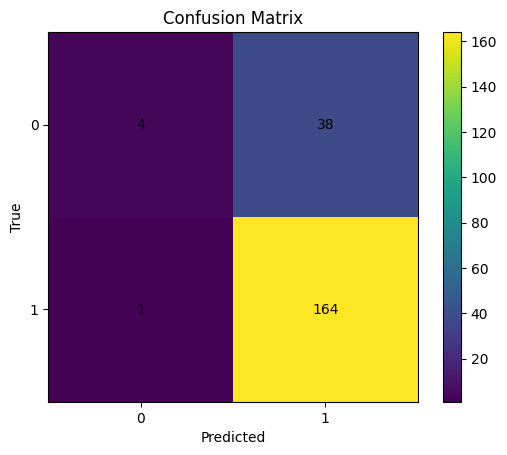

In [11]:

cm = confusion_matrix(out_df["label"], out_df["pred_label"])
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(out_df["label"], out_df["pred_label"], digits=3))

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xticks([0,1],[0,1])
plt.yticks([0,1],[0,1])
plt.colorbar()
plt.show()


## 5.2) Confusion Matrix (threshold 0.85)

Using decision threshold: 0.85
Coefficients:
used_correct_sources         +1.000
extracted_correct_insights   -0.108
format_reasonable            +0.843
answers_completely           +1.288
needs_more_context           +0.556
Intercept: -1.330
Confusion matrix:
 [[ 42   0]
 [150  15]]

Classification report:
               precision    recall  f1-score   support

           0      0.219     1.000     0.359        42
           1      1.000     0.091     0.167       165

    accuracy                          0.275       207
   macro avg      0.609     0.545     0.263       207
weighted avg      0.841     0.275     0.206       207



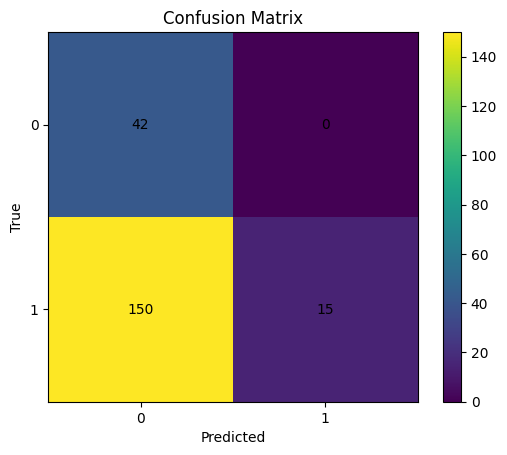

In [16]:
feature_cols = ["used_correct_sources","extracted_correct_insights","format_reasonable","answers_completely","needs_more_context"]
X = out_df[feature_cols].astype(int).values
y = out_df["label"].values

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

THRESHOLD = 0.85

out_df["pred_proba"] = clf.predict_proba(X)[:, 1]
out_df["pred_label"] = (out_df["pred_proba"] >= THRESHOLD).astype(int)

print(f"Using decision threshold: {THRESHOLD}")
print("Coefficients:")
for name, w in zip(feature_cols, clf.coef_[0]):
    print(f"{name:28s} {w:+.3f}")
print("Intercept:", f"{clf.intercept_[0]:+.3f}")

cm = confusion_matrix(out_df["label"], out_df["pred_label"])
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(out_df["label"], out_df["pred_label"], digits=3))

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xticks([0,1],[0,1])
plt.yticks([0,1],[0,1])
plt.colorbar()
plt.show()


## 6.1) Predicted probability vs original grade boxplot

/var/folders/0m/9xl56lfx05q0fjkbpc87b0d40000gn/T/ipykernel_76872/2723387867.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=unique_cats, showmeans=True)


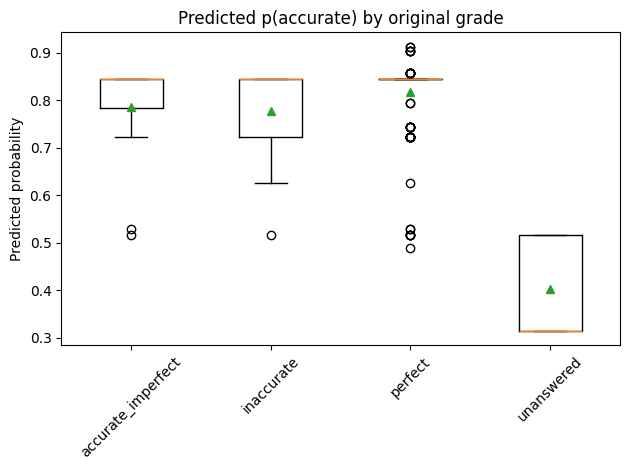

In [9]:

cats = out_df[GRADE_COL].astype(str).fillna("NA")
unique_cats = sorted(cats.unique())
groups = [out_df.loc[cats == c, "pred_proba"].values for c in unique_cats]

plt.figure()
plt.boxplot(groups, labels=unique_cats, showmeans=True)
plt.title("Predicted p(accurate) by original grade")
plt.ylabel("Predicted probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6.2) Predicted probability vs original grade means

In [15]:
# Means by category in the same order as the boxplot labels
means = {c: float(out_df.loc[cats == c, "pred_proba"].mean()) for c in unique_cats}

print("Mean predicted probability by original grade:")
for c in unique_cats:
    print(f"{c}: {means[c]:.4f}")


Mean predicted probability by original grade:
accurate_imperfect: 0.7856
inaccurate: 0.7771
perfect: 0.8173
unanswered: 0.4020
